In [1]:
%%HTML
<style>.container{width:100%;}</style>

Dieses Notebook hängt vom Notebook `2-Ordered-Sets.ipynb` ab. Es hängt auch von Dateien im Ordner `Aux` ab, die aus [diesen Vorlesungsunterlagen von Stroetmann](https://github.com/karlstroetmann/Algorithms/tree/master/Python "K. Stroetmann (2020): Algorithms/Python, GitHub") abgeleitet wurden; den Notebooks `Set.ipynb` und `HashMap.ipynb`. Ebenfalls hängt es von einer `Aux`-Datei aus [diesen Vorlesungsunterlagen von Stroetmann](https://github.com/karlstroetmann/Artificial-Intelligence/tree/master/Python/1%20Search "K. Stroetmann (2020): Artificial-Intelligence/Python/1 Search, GitHub") ab.

Help on class set in module builtins:

class set(object)
 |  set() -> new empty set object
 |  set(iterable) -> new set object
 |  
 |  Build an unordered collection of unique elements.
 |  
 |  Methods defined here:
 |  
 |  __and__(self, value, /)
 |      Return self&value.
 |  
 |  __contains__(...)
 |      x.__contains__(y) <==> y in x.
 |  
 |  __eq__(self, value, /)
 |      Return self==value.
 |  
 |  __ge__(self, value, /)
 |      Return self>=value.
 |  
 |  __getattribute__(self, name, /)
 |      Return getattr(self, name).
 |  
 |  __gt__(self, value, /)
 |      Return self>value.
 |  
 |  __iand__(self, value, /)
 |      Return self&=value.
 |  
 |  __init__(self, /, *args, **kwargs)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __ior__(self, value, /)
 |      Return self|=value.
 |  
 |  __isub__(self, value, /)
 |      Return self-=value.
 |  
 |  __iter__(self, /)
 |      Implement iter(self).
 |  
 |  __ixor__(self, value, /)
 |      Re

Autosave disabled


andre


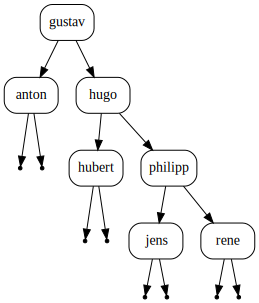

anton


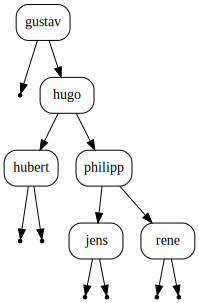

gustav


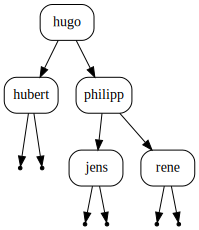

hubert


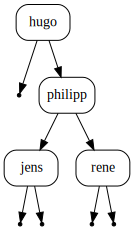

hugo


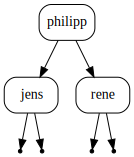

jens


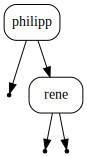

philipp


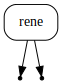

rene


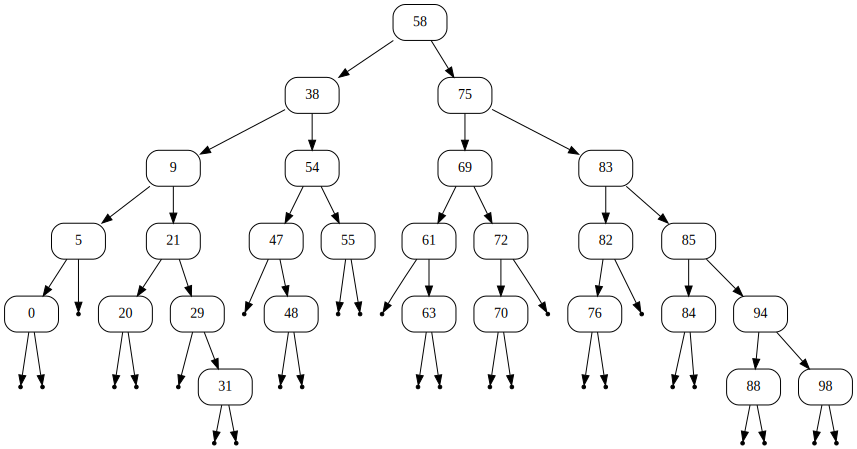

0 5 9 20 21 29 31 38 47 48 54 55 58 61 63 69 70 72 75 76 82 83 84 85 88 94 98 

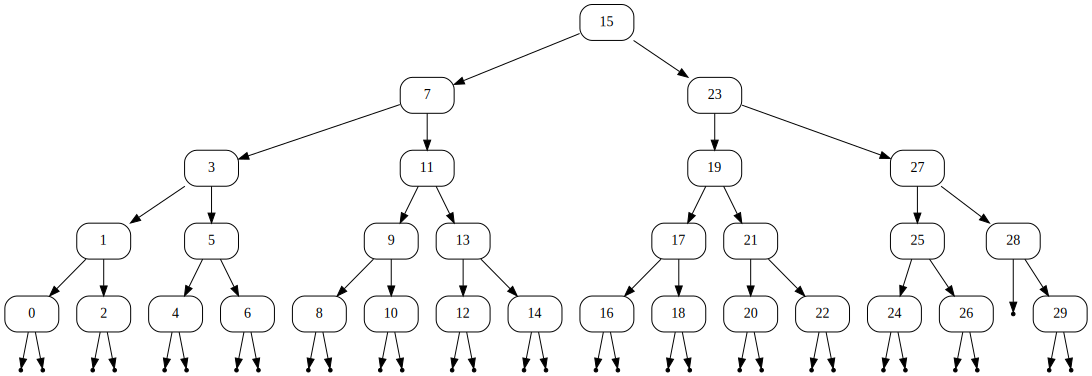

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 

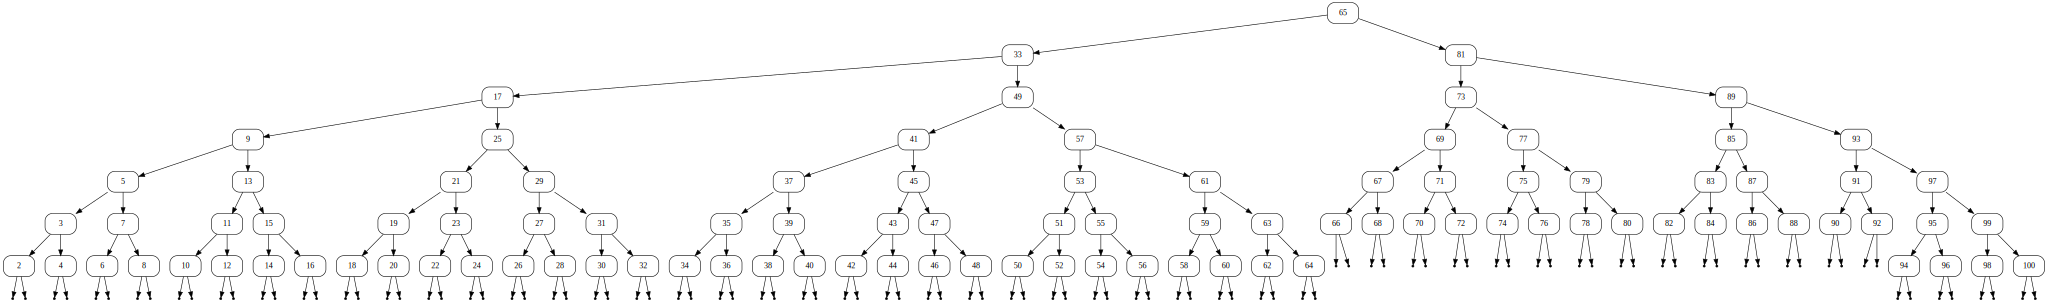

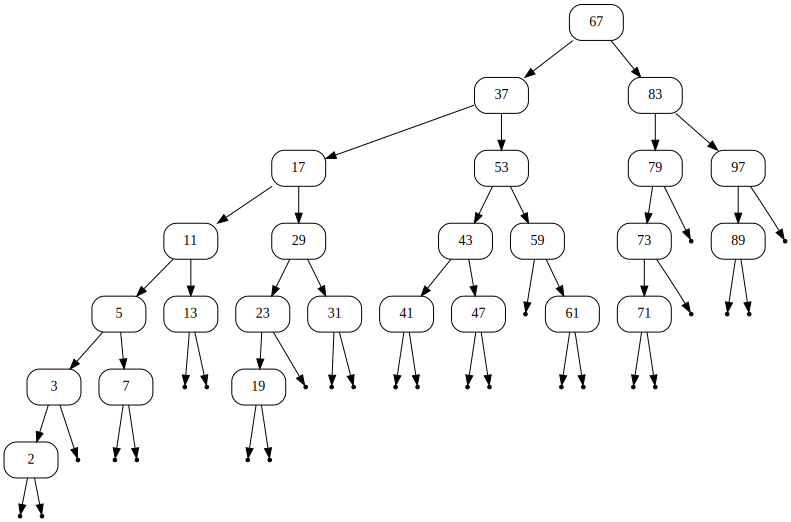

2 3 5 7 11 13 17 19 23 29 31 37 41 43 47 53 59 61 67 71 73 79 83 89 97 

Autosave disabled


mEntries = 6 mSize = 3
mEntries = 14 mSize = 7


In [2]:
%run 2-Ordered-Sets.ipynb
%run Aux/Set.ipynb
%run Aux/HashMap.ipynb
%run Aux/Sliding-Puzzle.ipynb

Wir importieren außerdem aus `sys.setrecursionlimit`, mit dem wir die Anzahl erlaubter Rekursionen setzen, und `statistics.median`, mit der wir den Median aus mehreren Testläufen berechnen. Beide sind aus der Standard Library.

In [3]:
from statistics import median
from sys import setrecursionlimit

# Performance

Wir werden, was die Performance betrifft, mit verschiedenen Benchmarks zwei Arten von Vergleichen anstellen:

- Wir vergleichen die geordneten Mengen auf Basis von Splay Trees mit geordneten Mengen auf Basis anderer Datenstrukturen, wobei wir die Python-Implementierung mit rekursivem Splaying mit *AVL-Bäumen* und Hashtabellen vergleichen. Die Implementierungen dieser Strukturen sind ebenfalls in Python und im Fall der AVL-Bäume auch rekursiv.
- Wir vergleichen die rekursive Splay-Implementierung mit einer iterativen Implementierung sowie mit einer iterativen Implementierung, bei der die Schritte als Inline geschrieben sind.
- Wir vergleichen für die praktische Anwendbarkeit die Cython-Implementierung mit iterativem Splaying mit den nativen, in C implementierten Python-Mengen. Dieser Vergleich ist nicht ganz fair, weil auch Cython nicht auf Augenhöhe mit purem C ist, aber dennoch interessiert uns, wie groß der Unterschied wirklich ist. Wir nehmen auch den Vergleich mit der reinen Python-Implementierung auf höchstem Optimierungslevel hinzu, weil uns der Speedup der Cython-Implementierung interessiert.

## Vergleichsobjekte

Wir benutzen die auf *AVL-Bäumen* basierende Implementierung `Set` sowie die Hashtabellenimplementierung `HashTable` von [Stroetmann](https://github.com/karlstroetmann/Algorithms/tree/master/Python "K. Stroetmann (2020): Algorithms/Python, GitHub"). Für diese müssen wir einige Methoden hinzufügen, die für unsere Tests benötigt werden, die aber nicht in diesen Implementierungen vorhanden sind.

### Erweiterung von `Set` (AVL-Bäume)

Wir erweitern `Set` dahingehend, dass eine Konstruktion aus einem Iterablen möglich ist. Da in Python keine Konstruktorpolymorphie erlaubt ist, überschreiben wir den Konstruktor von `Set`, wobei wir zunächst den Code des ursprünglichen Konstruktors übernehmen, und danach gegebenenfalls die Elemente einfügen.

In [4]:
def __init__(self, iterable=[]):
    self.mKey    = None
    self.mLeft   = None
    self.mRight  = None
    self.mHeight = 0
    for el in iterable:
        self.insert(el)

Set.__init__ = __init__
del __init__

Wir wollen `add`, das Hinzufügen eines Elementes, unterstützen. Dies ist mit `insert` schon vorhanden, ist jedoch nicht die Bezeichnung von Python-Mengen und somit auch von `OrderedSet`

In [5]:
Set.add = Set.insert

`discard`, das Entfernen, das auch für nicht vorhandene Elemente definiert ist, soll unterstützt werden. Wir setzen `discard` auf das vorhandene `delete`.

In [6]:
Set.discard = Set.delete

Die Funktionalität von `delete` ändern wir nicht; dies bedeutet, dass in den Tests nie eine Konstruktion wie diese hier verwendet werden darf:

```
try:
    some_set.remove(some_element)
except KeyError:
    ...
```

Anders gesagt: Die folgenden Performancetests dürfen nicht erwarten, dass beim Entfernen eines Elements aus einer Menge auch dann kein Fehler gehoben wird, wenn dieses Element nicht in der Menge vorhanden ist.

Um `Set`s ausgeben zu können, implementieren wir zunächst `__iter__` ähnlich wie beim `OrderedSet` in Form einer In-Order-Ausgabe.

In [7]:
def __iter__(self):
    stack = collections.deque()
    tree  = self
    while stack or tree is not None:
        if tree is not None:
            stack.append(tree)
            tree = tree.mLeft
            continue
        tree = stack.pop()
        if tree.mKey is not None:
            yield tree.mKey
        tree = tree.mRight

Set.__iter__ = __iter__
del __iter__

Zur eigentlichen Ausgabe implementieren wir ebenfalls ähnlich wie beim `OrderedSet`:

In [8]:
def __repr__(self):
    return f"{type(self).__name__}({list(self)})"

Set.__repr__ = __repr__
del __repr__

Zur Unterstützung von beliebigen Elementen geben wir `Set` die Methoden `_arb_lt`, `_arb_eq` und `_arb_gt` von `Node` und benutzen diese in den existierenden Methoden `member`, `insert` und `delete`.

In [9]:
Set._arb_lt = Node._arb_lt
Set._arb_eq = Node._arb_eq
Set._arb_gt = Node._arb_gt

def member(self, key):
    if self.isEmpty():
        return
    elif self._arb_eq(self.mKey, key):
        return True
    elif self._arb_lt(key, self.mKey):
        return self.mLeft.member(key)
    else:
        return self.mRight.member(key)

def insert(self, key):
    if self.isEmpty():
        self.mKey    = key
        self.mLeft   = Set()
        self.mRight  = Set()
        self.mHeight = 1
    elif self._arb_eq(self.mKey, key):
        pass
    elif self._arb_lt(key, self.mKey):
        self.mLeft.insert(key)
        self._restore()
    else:
        self.mRight.insert(key)
        self._restore()

def delete(self, key):
    if self.isEmpty():
        return
    if self._arb_eq(key, self.mKey):
        if self.mLeft.isEmpty():
            self._update(self.mRight)
        elif self.mRight.isEmpty():
            self._update(self.mLeft)
        else:
            self.mRight, self.mKey = self.mRight._delMin()
    elif self._arb_lt(key, self.mKey):
        self.mLeft.delete(key)
    else:
        self.mRight.delete(key)

Set.member = member
Set.insert = insert
Set.delete = delete
del member, insert, delete

Zur Unterstützung von `Set`s von `Set`s müssen wir die Ordnungen `<` und `==` (`__lt__` und `__eq__`) zwischen `Set`s ermöglichen. Hier können wir die lexikographische Ordnung ähnlich wie bei `OrderedSet` implementieren. Wir verzichten auf das Anheben von `TypeError`s, wenn die Typen inkompatibel sind. Somit dürfen die Tests keine Konstruktion wie diese hier verwenden:

```
try:
    if some_set < some_mysterious_object:
        ...
except TypeError:
    ...
```

In [10]:
def __lt__(self, other):
    x_iter, y_iter = iter(self), iter(other)
    while True:
        try:
            y_item = next(y_iter)
        except StopIteration:
            return False
        try:
            x_item = next(x_iter)
        except StopIteration:
            return True
        if self._arb_lt(x_item, y_item):
            return True
        if self._arb_gt(x_item, y_item):
            return False

def __eq__(self, other):
    x_iter, y_iter = iter(self), iter(other)
    while True:
        try:
            x_item = next(x_iter)
        except StopIteration:
            try:
                next(y_iter)
            except StopIteration:
                return True
            return False
        try:
            y_item = next(y_iter)
        except StopIteration:
            return False
        if not self._arb_eq(x_item, y_item):
            return False

Set.__lt__ = __lt__
Set.__eq__ = __eq__
del __lt__, __eq__

Wir redefinieren `Set.isEmpty` und `Set.pop`, weil sie für den Vergleich mit `None` den Operator `==` statt `is` verwenden. Das funktioniert nicht mehr, wenn wir `Set.__eq__` gesetzt haben.

In [11]:
def isEmpty(self):
    return self.mKey is None

def pop(self):
    if self.mKey is None:
        raise KeyError
    if self.mLeft.mKey is None:
        key = self.mKey
        self._update(self.mRight)
        return key
    return self.mLeft.pop()

Set.isEmpty = isEmpty
Set.pop     = pop
del isEmpty, pop

`copy`, `__sub__` (`-`) und `__or__` (`|`) implementieren wir ähnlich wie in `OrderedSet`, wieder ohne Typüberprüfung.

In [12]:
def copy(self):
    return type(self)(self)

def __sub__(self, other):
    difference = type(self)(self)
    for el in other:
        difference.discard(el)
    return difference

def __or__(self, other):
    intersection = type(self)(self)
    for el in other:
        intersection.insert(el)
    return intersection

Set.copy = copy
Set.__sub__ = __sub__
Set.__or__ = __or__
del copy, __sub__, __or__

`__len__` können wir von `OrderedSet` übernehmen.

In [13]:
Set.__len__ = OrderedSet.__len__

### Erweiterung von `HashTable`

Wir werden nicht `HashTable` direkt ansprechen, da diese Implementierung ein wichtiges Detail enthält, das wir bei der Verwendung der `HashTable`s als Menge nicht sichtbar haben wollen: Die Tabellen werden mit einer spezifizierten Größe konstruiert, und auf diese Funktion wird auch in den anderen Methoden von `HashTable` noch zugegriffen. Daher bauen wir die Klasse `HashSet`, die einen `HashTable` vorhält. Dieser wird anfangs mit der Defaultgröße 256 erstellt. Wir unterstützen die Konstruktion aus einem Iterablen. Der `HashTable` ist eigentlich ein Dictionary und keine Menge, somit speichern wir für jeden Schlüssel den Wert `True` ab.

In [14]:
class HashSet:
    def __init__(self, iterable=[]):
        self.set = HashTable(256)
        for el in iterable:
            self.set.insert(el, True)

Wir überschreiben für `HashTable` die Definition von `hash_code`, die nur mit Strings funktioniert, indem wir einfach `hash` aufrufen und den übergebenen Modul anwenden.

In [15]:
def hash_code(value, modulus):
    return hash(value) % modulus

Wir müssen eine Hashfunktion für die Mengen selbst definieren, damit Mengen von Mengen ermöglicht werden. Wir summieren dafür die Hashwerte aller Elemente auf und können dabei die Implementierung von `OrderedFrozenset` übernehmen.

In [16]:
HashSet.__hash__ = OrderedFrozenset.__hash__

Auch einen Gleichheitsbegriff für `HashSet`s benötigen wir. Wir überprüfen zunächst, ob die beiden Tabellen gleich lang sind, und überprüfen in diesem Fall alle Zellen mithilfe vom hash-basierten [`Counter`](https://docs.python.org/3.7/library/collections.html#collections.Counter "Python Software Foundation (2020): The Python Standard Library/Data Types/collections/Counter, Python Documentation") aus den `collections`.

In [17]:
def __eq__(self, other):
    if self.set.mSize != other.set.mSize:
        return False
    for cell_x, cell_y in zip(self.set.mArray, other.set.mArray):
        if collections.Counter(cell_x) != collections.Counter(cell_y):
            return False
    return True

HashSet.__eq__ = __eq__
del __eq__

Des weiteren rufen wir für `insert` und `discard` respektive die Methoden `insert` und `delete` auf. Die Verwendung von `insert` erleichtert die Wiederverwendung von Methoden von `Set`.

In [18]:
def insert(self, element):
    self.set.insert(element, True)

def discard(self, element):
    self.set.delete(element)

HashSet.insert  = insert
HashSet.discard = discard
del insert, discard

Wir implementieren auch ein `__iter__` zur Stringdarstellung von `HashSet`s, wobei wir alle belegten Schlüssel anzeigen, und übernehmen `__repr__` von `Set`.

In [19]:
def __iter__(self):
    for cell in self.set.mArray:
        for el in cell:
            yield el[0]

HashSet.__iter__ = __iter__
del __iter__
HashSet.__repr__ = Set.__repr__

Ferner entfernen wir aus der Originalimplementierung von `HashTable` das `print`-Statement in `insert`, das hier nicht benötigt wird.

In [20]:
def insert(self, key, value):
    if self.mEntries >= self.mSize * self.mAlpha:
        self._rehash()
    index = hash_code(key, self.mSize)
    aList = self.mArray[index]
    for i, (k, v) in enumerate(aList):
        if k == key:
            aList[i] = (key, value)
            return
    self.mEntries += 1
    aList.append((key, value))

HashTable.insert = insert
del insert

Für `pop` entfernen wir das erstbeste Element aus dem Array.

In [21]:
def pop(self):
    for cell in self.set.mArray:
        if cell:
            el = cell.pop()[0]
            self.set.mEntries -= 1
            return el

HashSet.pop = pop
del pop

Die Implementierungen von `copy`, `__sub__` (`-`) und `__or__` (`|`) waren in `Set` so gehalten, dass wir sie jetzt wiederverwenden können.

In [22]:
HashSet.copy = Set.copy
HashSet.__sub__ = Set.__sub__
HashSet.__or__  = Set.__or__

Zuletzt benötigen wir `__len__` für die Länge, die schon vorgehalten wird.

In [23]:
def __len__(self):
    return self.set.mEntries

HashSet.__len__ = __len__
del __len__

### Effizientere `_splay`-Implementierungen

Wir wollen unsere Python-Implementierung von `_splay`, die rekursiv und mit Funktionsaufrufen der eigentlichen Splay-Schritte funktioniert, vergleichen mit einer iterativen Version, sowie mit einer iterativen Version, die diese Schritte *inline* vollzieht.

Dazu definieren wir `_iterative_splay`…

In [24]:
def _iterative_splay(self, payload):
    max_less = min_greater = set_aside = Node(None, None, None)
    while True:
        if self._arb_lt(payload, self.payload):
            if self.left is None:
                break
            if self._arb_lt(payload, self.left.payload) \
                    and self.left.left is not None:
                max_less, self, min_greater = self._zig_zig(max_less,
                                                            min_greater)
                continue
            if self._arb_gt(payload, self.left.payload) \
                    and self.left.right is not None:
                max_less, self, min_greater = self._zig_zag(max_less,
                                                            min_greater)
                continue
            max_less, self, min_greater = self._zig(max_less, min_greater)
            break
        if self._arb_gt(payload, self.payload):
            if self.right is None:
                break
            if self._arb_gt(payload, self.right.payload) \
                    and self.right.right is not None:
                max_less, self, min_greater = self._zag_zag(max_less,
                                                            min_greater)
                continue
            if self._arb_lt(payload, self.right.payload) \
                    and self.right.left is not None:
                max_less, self, min_greater = self._zag_zig(max_less,
                                                            min_greater)
                continue
            max_less, self, min_greater = self._zag(max_less, min_greater)
            break
        break
    max_less.right   = self.left
    min_greater.left = self.right
    self.left        = set_aside.right
    self.right       = set_aside.left
    return self

…und `_iterative_inline_splay`.

In [25]:
def _iterative_inline_splay(self, payload):
    max_less = min_greater = set_aside = Node(None, None, None)
    while True:
        if self._arb_lt(payload, self.payload):
            if self.left is None:
                break
            if self._arb_lt(payload, self.left.payload) \
                    and self.left.left is not None:
                tmp              = self.left
                self.left        = tmp.right
                tmp.right        = self
                min_greater.left = tmp
                min_greater      = tmp
                self             = tmp.left
                continue
            if self._arb_gt(payload, self.left.payload) \
                    and self.left.right is not None:
                max_less.right   = self.left
                max_less         = self.left
                min_greater.left = self
                min_greater      = self
                self             = self.left.right
                continue
            min_greater.left     = self
            min_greater          = self
            self                 = self.left
            break
        if self._arb_gt(payload, self.payload):
            if self.right is None:
                break
            if self._arb_gt(payload, self.right.payload) \
                    and self.right.right is not None:
                tmp              = self.right
                self.right       = tmp.left
                tmp.left         = self
                max_less.right   = tmp
                max_less         = tmp
                self             = tmp.right
                continue
            if self._arb_lt(payload, self.right.payload) \
                    and self.right.left is not None:
                max_less.right   = self
                max_less         = self
                min_greater.left = self.right
                min_greater      = self.right
                self             = self.right.left
                continue
            max_less.right       = self
            max_less             = self
            self                 = self.right
            break
        break
    max_less.right   = self.left
    min_greater.left = self.right
    self.left        = set_aside.right
    self.right       = set_aside.left
    return self

## Anwendungsbeispiel: Sieb des Eratosthenes

Als Anwendungsbeispiel benutzen wir die zu testenden Mengen, um alle Primzahlen bis zu einem Maximum abzulegen. Die Primzahlen werden dabei mit dem Sieb des Eratosthenes berechnet. Die Implementierung ist sehr einfach gehalten und hat Raum für Optimierungen, aber das ist für den Vergleich untereinander unproblematisch. Wir schreiben die Funktion so, dass zur Laufzeit die Klasse, die für die Menge benutzt werden soll, übergeben werden kann.

In [26]:
def primes(n, TestSet):
    primes = TestSet(range(2, n + 1))
    for i in range(2, n + 1):
        for j in range(2 * i, n + 1, i):
            primes.discard(j)
    return primes

Wir berechnen probeweise die Primzahlen bis 100.

In [27]:
test_n = 100
print(f"           {primes(test_n, set)}")
print(f"{primes(test_n, OrderedSet)}")
print(f"       {primes(test_n, Set)}")
print(f"   {primes(test_n, HashSet)}")

           {2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97}
OrderedSet([2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97])
       Set([2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97])
   HashSet([2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97])


Wir verfassen für die Darstellung der Zeiten noch einen kleinen Formatter. Er benutzt den Median der gemessenen Zeiten.

In [28]:
def fmt_times(self_times, other_times, other_op, self_op="Splay trees"):
    self_time  = median(self_times.timings)
    other_time = median(other_times.timings)
    if self_time > other_time:
        print(f"{self_op} were {round(self_time / other_time, 2)} " +
              f"times slower than {other_op}")
    else:
        print(f"{self_op} were {round(other_time / self_time, 2)} " +
              f"times faster than {other_op}")

Wir betrachten nun vergleichend die Ausführungszeiten der in Python implementierten Datenstrukturen. Wir setzen dabei das Rekursionslimit entsprechend hoch, sodass die rekursive Splay-Tree-Implementierung damit umgehen kann. In Python [gibt es keine Tail Recursion Elimination](https://neopythonic.blogspot.com/2009/04/tail-recursion-elimination.html "G. v. Rossum (2009): Neopythonic: Tail Recursion Eliminiation"), wenn es sie gäbe, dann wäre dies nicht erforderlich, weil wir in `_splay` immer nur im Return-Statement rekursiv aufrufen.

In [29]:
n = 10**4
setrecursionlimit(n)

# Ignore missing whitespace around operator because this is actually a flag
# Ignore syntax error that flake8 sees due to a compatibility issue
splay_times = %timeit -o primes(n, OrderedSet)  # noqa: E225, E999
avl_times   = %timeit -o primes(n, Set)         # noqa: E225
hash_times  = %timeit -o primes(n, HashSet)     # noqa: E225

fmt_times(splay_times, avl_times, "AVL trees")
fmt_times(splay_times, hash_times, "hash maps")

529 ms ± 16.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
637 ms ± 18.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
102 ms ± 16.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Splay trees were 1.24 times faster than AVL trees
Splay trees were 4.63 times slower than hash maps


Wir vergleichen auch die Optimierungen für Splaying, die nur im Code stattfinden.

In [30]:
Node._splay = _iterative_splay
print(f"           {primes(test_n, set)}")
print(f"{primes(test_n, OrderedSet)}")
iterative_splay_times = %timeit -o primes(n, OrderedSet)  # noqa: E225, E999
print(f"{primes(test_n, OrderedSet)}")
Node._splay = _iterative_inline_splay
iterative_inline_splay_times = %timeit -o primes(n, OrderedSet)  # noqa: E225

fmt_times(iterative_splay_times, splay_times,
          "recursive splaying", self_op="Iterative splay trees")
fmt_times(iterative_inline_splay_times, splay_times,
          "recursive splaying", self_op="Iterative inline splay trees")

           {2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97}
OrderedSet([2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97])
491 ms ± 29.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
OrderedSet([2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97])
417 ms ± 19.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Iterative splay trees were 1.08 times faster than recursive splaying
Iterative inline splay trees were 1.25 times faster than recursive splaying


Zum Vergleich mit den nativen Mengen tauschen wir die Implementierung der Splay Trees mit der Cython-Implementierung aus. Wir vergleichen noch einmal den Output mit dem von `set`:

In [31]:
%run 3-Cython.ipynb
print(f"           {primes(test_n, set)}")
print(f"{primes(test_n, OrderedSet)}")

           {2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97}
OrderedSet([2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97])


Im Performancevergleich betrachten wir Python-Splaying, Cython-Splaying und native Mengen. Wir benutzen für Python die am höchsten optimierte Version.

In [32]:
splay_cython_times = %timeit -o primes(n, OrderedSet)  # noqa: E225, E999
native_times       = %timeit -o primes(n, set)         # noqa: E225
fmt_times(splay_cython_times, native_times,
          "native sets", self_op="Cython splay trees")
fmt_times(splay_cython_times, iterative_inline_splay_times,
          "optimised Python splay trees", self_op="Cython splay trees")

55.4 ms ± 704 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
9.39 ms ± 91.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Cython splay trees were 5.9 times slower than native sets
Cython splay trees were 7.49 times faster than optimised Python splay trees


Wir laden zunächst wieder die reguläre Implementierung.

In [33]:
%run 2-Ordered-Sets.ipynb

The pycodestyle_magic extension is already loaded. To reload it, use:
  %reload_ext pycodestyle_magic
Help on class set in module builtins:

class set(object)
 |  set() -> new empty set object
 |  set(iterable) -> new set object
 |  
 |  Build an unordered collection of unique elements.
 |  
 |  Methods defined here:
 |  
 |  __and__(self, value, /)
 |      Return self&value.
 |  
 |  __contains__(...)
 |      x.__contains__(y) <==> y in x.
 |  
 |  __eq__(self, value, /)
 |      Return self==value.
 |  
 |  __ge__(self, value, /)
 |      Return self>=value.
 |  
 |  __getattribute__(self, name, /)
 |      Return getattr(self, name).
 |  
 |  __gt__(self, value, /)
 |      Return self>value.
 |  
 |  __iand__(self, value, /)
 |      Return self&=value.
 |  
 |  __init__(self, /, *args, **kwargs)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __ior__(self, value, /)
 |      Return self|=value.
 |  
 |  __isub__(self, value, /)
 |      Return self-=value.

## Anwendungsbeispiel: Algorithmus von Davis und Putnam für das $n$-Damen-Problem

In einem weiteren Anwendungsbeispiel benutzen wir die zu testenden Mengen, um den Algorithmus von Davis und Putnam zu implementieren, wobei die Implementierung an [Stroetmann](https://github.com/karlstroetmann/Logic/tree/master/Python "K. Stroetmann (2020): Logic/Python, GitHub") orientiert ist. Damit werden wir das $n$-Damen-Problem lösen, welches als aussagenlogisches Problem aufgefasst wird (Implementierung in der gleichen Quelle). Beim $n$-Damen-Problem ist das Ziel, $n$ Damen auf ein $n \times n$-Schachbrett zu platzieren, sodass keine Dame eine andere Dame gemäß den Regeln des Schachspiels bedroht.

Wir implementieren dafür zunächst alle Methoden des Algorithmus von Davis und Putnam. Dabei übernehmen wir die Implementierung aus dem Repository, geben allen Methoden aber die zu verwendenden Klassen für veränderliche und unveränderliche Mengen mit, und verwenden im Folgenden diese Klassen.

In [34]:
def complement(l, TestSet, TestFrozenset):
    if isinstance(l, str):
        return ('¬', l)
    else:
        return l[1]

def extractVariable(l, TestSet, TestFrozenset):
    if isinstance(l, str):
        return l
    else:
        return l[1]

def arb(S, TestSet, TestFrozenset):
    for x in S:
        return x

def selectVariable(Clauses, Forbidden, TestSet, TestFrozenset):
    returnable = arb(TestSet([extractVariable(L, TestSet, TestFrozenset)
                              for C in Clauses for L in C]) - Forbidden,
                     TestSet, TestFrozenset)
    return returnable

def reduce(Clauses, l, TestSet, TestFrozenset):
    lBar = complement(l, TestSet, TestFrozenset)
    return (TestSet([C - TestSet([lBar]) for C in Clauses if lBar in C])
            | TestSet([C for C in Clauses if lBar not in C and l not in C])
            | TestSet([TestFrozenset(TestSet([l]))]))

def saturate(Clauses, TestSet, TestFrozenset):
    S     = Clauses.copy()
    Units = TestSet([C for C in S if len(C) == 1])
    Used  = TestSet()
    while len(Units) > 0:
        unit = Units.pop()
        Used |= TestSet([unit])
        l = arb(unit, TestSet, TestFrozenset)  # noqa: E741
        S = reduce(S, l, TestSet, TestFrozenset)
        Units = TestSet([C for C in S if len(C) == 1]) - Used
    return S

def solve(Clauses, Variables, TestSet, TestFrozenset):
    S      = saturate(Clauses, TestSet, TestFrozenset)
    empty  = TestFrozenset()
    Falsum = TestSet([empty])
    if empty in S:
        return Falsum
    if all(len(C) == 1 for C in S):
        return S
    p = selectVariable(S, Variables, TestSet, TestFrozenset)
    negP = complement(p, TestSet, TestFrozenset)
    Result = solve(S | TestSet([TestFrozenset(TestSet([p]))]),
                   Variables | TestSet([p]), TestSet, TestFrozenset)
    if Result != Falsum:
        return Result
    return solve(S | TestSet([TestFrozenset(TestSet([negP]))]),
                 Variables | TestSet([p]), TestSet, TestFrozenset)

Auch reimplementieren wir die nötigen Methoden für die Spezifikation des $n$-Damen-Problems.

In [35]:
def var(row, col, TestSet, TestFrozenset):
    return "Q(" + str(row) + "," + str(col) + ")"

def atMostOne(S, TestSet, TestFrozenset):
    return TestSet([TestFrozenset(TestSet([("¬", p), ("¬", q)])) for p in S
                    for q in S
                    if p != q])

def atMostOneInRow(row, n, TestSet, TestFrozenset):
    return atMostOne(TestSet([var(row, col, TestSet, TestFrozenset)
                              for col in range(1, n + 1)]),
                     TestSet, TestFrozenset)

def oneInColumn(col, n, TestSet, TestFrozenset):
    return TestSet([TestFrozenset(TestSet([var(row, col,
                                               TestSet, TestFrozenset)
                                           for row in range(1, n + 1)]))])

def atMostOneInFallingDiagonal(k, n, TestSet, TestFrozenset):
    S = TestSet([var(row, col, TestSet, TestFrozenset)
                 for row in range(1, n + 1)
                 for col in range(1, n + 1)
                 if row - col == k])
    return atMostOne(S, TestSet, TestFrozenset)

def atMostOneInRisingDiagonal(k, n, TestSet, TestFrozenset):
    S = TestSet([var(row, col, TestSet, TestFrozenset)
                 for row in range(1, n + 1)
                 for col in range(1, n + 1)
                 if row + col == k])
    return atMostOne(S, TestSet, TestFrozenset)

def allClauses(n, TestSet, TestFrozenset):
    All = ([atMostOneInRow(row, n, TestSet, TestFrozenset)
            for row in range(1, n + 1)] +
           [atMostOneInRisingDiagonal(k, n, TestSet, TestFrozenset)
            for k in range(3, (2 * n - 1) + 1)] +
           [atMostOneInFallingDiagonal(k, n, TestSet, TestFrozenset)
            for k in range(-(n - 2), (n - 2) + 1)] +
           [oneInColumn(col, n, TestSet, TestFrozenset)
            for col in range(1, n + 1)])
    return TestSet([clause for S in All for clause in S])

def printBoard(I, n, TestSet, TestFrozenset):
    if I == TestSet([TestFrozenset()]):  # noqa: E741
        return
    print("-" * (8 * n + 1))
    for row in range(1, n + 1):
        printEmptyLine(n, TestSet, TestFrozenset)
        line = "|"
        for col in range(1, n + 1):
            if TestFrozenset(TestSet([var(row, col,
                                          TestSet, TestFrozenset)])) in I:
                line += "   Q   |"
            else:
                line += "       |"
        print(line)
        printEmptyLine(n, TestSet, TestFrozenset)
        print("-" * (8 * n + 1))

def printEmptyLine(n, TestSet, TestFrozenset):
    line = "|"
    for col in range(1, n + 1):
        line += "       |"
    print(line)

def queens(n, TestSet, TestFrozenset):
    Clauses  = allClauses(n, TestSet, TestFrozenset)
    Solution = solve(Clauses, TestSet(), TestSet, TestFrozenset)
    if Solution != TestSet([TestFrozenset()]):
        return Solution
    else:
        print(f"The problem is not solvable for {n} queens!")

So können wir in allen Varianten das $n$-Damen-Problem lösen. Im Fall `Set` geben wir dem Problem auch für unveränderliche Mengen das `Set` mit – das ist kein Problem, weil korrekt mit veränderlichen und unveränderlichen Mengen umgegangen wird, d. h. es wird nie der Versuch unternommen, eine unveränderliche Menge zu verändern, oder eine veränderliche Menge in einer Menge oder in einem Dictionary abzulegen. Ähnlich gehen wir mit `HashSet` um.

In [36]:
test_n = 4
printBoard(queens(test_n, set, frozenset), test_n, set, frozenset)
printBoard(queens(test_n, OrderedSet, OrderedFrozenset), test_n,
           OrderedSet, OrderedFrozenset)
printBoard(queens(test_n, Set, Set), test_n, Set, Set)
printBoard(queens(test_n, HashSet, HashSet), test_n, HashSet, HashSet)

---------------------------------
|       |       |       |       |
|       |       |   Q   |       |
|       |       |       |       |
---------------------------------
|       |       |       |       |
|   Q   |       |       |       |
|       |       |       |       |
---------------------------------
|       |       |       |       |
|       |       |       |   Q   |
|       |       |       |       |
---------------------------------
|       |       |       |       |
|       |   Q   |       |       |
|       |       |       |       |
---------------------------------
---------------------------------
|       |       |       |       |
|       |   Q   |       |       |
|       |       |       |       |
---------------------------------
|       |       |       |       |
|       |       |       |   Q   |
|       |       |       |       |
---------------------------------
|       |       |       |       |
|   Q   |       |       |       |
|       |       |       |       |
--------------

Im Datenstrukturen-Vergleich haben wir:

In [37]:
n = 5

# break incompatible with magic statement
splay_times = %timeit -o queens(n, OrderedSet, OrderedFrozenset)  # noqa: E225, E501, E999
avl_times   = %timeit -o queens(n, Set, Set)                      # noqa: E225
hash_times  = %timeit -o queens(n, HashSet, HashSet)              # noqa: E225

fmt_times(splay_times, avl_times, "AVL trees")
fmt_times(splay_times, hash_times, "hash maps")

804 ms ± 48.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.48 s ± 123 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.46 s ± 244 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Splay trees were 1.75 times faster than AVL trees
Splay trees were 2.9 times faster than hash maps


Bei den Optimierungen von Splaying auf Python-Ebene zeigen wir noch einmal die Beispiele und führen den Vergleich durch:

In [38]:
Node._splay = _iterative_splay
printBoard(queens(test_n, OrderedSet, OrderedFrozenset), test_n,
           OrderedSet, OrderedFrozenset)
iterative_splay_times = %timeit -o queens(n, OrderedSet, OrderedFrozenset)  # noqa: E225, E501, E999
Node._splay = _iterative_inline_splay
printBoard(queens(test_n, OrderedSet, OrderedFrozenset), test_n,
           OrderedSet, OrderedFrozenset)
iterative_inline_splay_times = %timeit -o queens(n, OrderedSet, OrderedFrozenset)  # noqa: E225, E501

fmt_times(iterative_splay_times, splay_times,
          "recursive splaying", self_op="Iterative splay trees")
fmt_times(iterative_inline_splay_times, splay_times,
          "recursive splaying", self_op="Iterative inline splay trees")

---------------------------------
|       |       |       |       |
|       |   Q   |       |       |
|       |       |       |       |
---------------------------------
|       |       |       |       |
|       |       |       |   Q   |
|       |       |       |       |
---------------------------------
|       |       |       |       |
|   Q   |       |       |       |
|       |       |       |       |
---------------------------------
|       |       |       |       |
|       |       |   Q   |       |
|       |       |       |       |
---------------------------------
641 ms ± 46.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
---------------------------------
|       |       |       |       |
|       |   Q   |       |       |
|       |       |       |       |
---------------------------------
|       |       |       |       |
|       |       |       |   Q   |
|       |       |       |       |
---------------------------------
|       |       |       |       |
|   Q   |     

Ebenfalls haben wir für Cython und die nativen Mengen:

In [39]:
%run 3-Cython.ipynb
printBoard(queens(test_n, OrderedSet, OrderedFrozenset), test_n,
           OrderedSet, OrderedFrozenset)
splay_cython_times = %timeit -o queens(n, OrderedSet, OrderedFrozenset)  # noqa: E225, E501, E999
native_times       = %timeit -o queens(n, set, frozenset)                # noqa: E225
fmt_times(splay_cython_times, native_times,
          "native sets", self_op="Cython splay trees")
fmt_times(splay_cython_times, iterative_inline_splay_times,
          "optimised Python splay trees", self_op="Cython splay trees")

The cython extension is already loaded. To reload it, use:
  %reload_ext cython
---------------------------------
|       |       |       |       |
|       |   Q   |       |       |
|       |       |       |       |
---------------------------------
|       |       |       |       |
|       |       |       |   Q   |
|       |       |       |       |
---------------------------------
|       |       |       |       |
|   Q   |       |       |       |
|       |       |       |       |
---------------------------------
|       |       |       |       |
|       |       |   Q   |       |
|       |       |       |       |
---------------------------------
293 ms ± 33.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.65 ms ± 24.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Cython splay trees were 182.55 times slower than native sets
Cython splay trees were 2.26 times faster than optimised Python splay trees


Wir laden wieder die normalen `OrderedSet`s.

In [40]:
%run 2-Ordered-Sets.ipynb

The pycodestyle_magic extension is already loaded. To reload it, use:
  %reload_ext pycodestyle_magic
Help on class set in module builtins:

class set(object)
 |  set() -> new empty set object
 |  set(iterable) -> new set object
 |  
 |  Build an unordered collection of unique elements.
 |  
 |  Methods defined here:
 |  
 |  __and__(self, value, /)
 |      Return self&value.
 |  
 |  __contains__(...)
 |      x.__contains__(y) <==> y in x.
 |  
 |  __eq__(self, value, /)
 |      Return self==value.
 |  
 |  __ge__(self, value, /)
 |      Return self>=value.
 |  
 |  __getattribute__(self, name, /)
 |      Return getattr(self, name).
 |  
 |  __gt__(self, value, /)
 |      Return self>value.
 |  
 |  __iand__(self, value, /)
 |      Return self&=value.
 |  
 |  __init__(self, /, *args, **kwargs)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __ior__(self, value, /)
 |      Return self|=value.
 |  
 |  __isub__(self, value, /)
 |      Return self-=value.

## Anwendungsbeispiel: A$^*$-Algorithmus für das Schiebepuzzle

In einem weiteren Anwendungsbeispiel implementieren wir den *A$^*$-Suchalgorithmus* mit austauschbaren Mengenimplementierungen, womit wir hinterher ein Schiebepuzzle lösen. Wir nutzen die Implementierung von [Stroetmann](https://github.com/karlstroetmann/Artificial-Intelligence/tree/master/Python/1%20Search "K. Stroetmann (2020): Artificial-Intelligence/Python/1 Search, GitHub"), wobei wir die bidirektionale Variante verwenden, die von Start **und** Ziel sucht. In dieser Implementierung wird die Prioritätswarteschlange für die als nächstes zu besuchenden Zustände als `Set` implementiert, hier werden geordnete Mengen genutzt. Wir werden daher auch lediglich `Set` und `OrderedSet` vergleichen und ansonsten auch native Mengen nutzen.

Wir beginnen mit dem Algorithmus selbst und implementieren den A$^*$-Algorithmus und seine Hilfsfunktionen:

In [41]:
def search(start, goal, next_states, heuristic, TestSet):
    estimate  = heuristic(start, goal)
    ParentA   = {start: start}
    ParentB   = {goal: goal}
    DistanceA = {start: 0}
    DistanceB = {goal: 0}
    EstimateA = {start: estimate}
    EstimateB = {goal: estimate}
    FrontierA = TestSet()
    FrontierB = TestSet()
    FrontierA.add((estimate, start))
    FrontierB.add((estimate, goal))
    while FrontierA and FrontierB:
        guessA, stateA = FrontierA.pop()
        guessB, stateB = FrontierB.pop()
        stateADist = DistanceA[stateA]
        stateBDist = DistanceB[stateB]
        if guessA <= guessB:
            FrontierB.add((guessB, stateB))
            for ns in next_states(stateA):
                oldEstimate = EstimateA.get(ns, None)
                newEstimate = stateADist + 1 + heuristic(ns, goal)
                if oldEstimate is None or newEstimate < oldEstimate:
                    ParentA[ns]   = stateA
                    DistanceA[ns] = stateADist + 1
                    EstimateA[ns] = newEstimate
                    FrontierA.add((newEstimate, ns))
                    if oldEstimate is not None:
                        FrontierA.discard((oldEstimate, ns))
                if DistanceB.get(ns, None) is not None:
                    return combinePaths(ns, ParentA, ParentB)
        else:
            FrontierA.add((guessA, stateA))
            for ns in next_states(stateB):
                oldEstimate = EstimateB.get(ns, None)
                newEstimate = stateBDist + 1 + heuristic(start, ns)
                if oldEstimate is None or newEstimate < oldEstimate:
                    ParentB[ns]   = stateB
                    DistanceB[ns] = stateBDist + 1
                    EstimateB[ns] = newEstimate
                    FrontierB.add((newEstimate, ns))
                    if oldEstimate is not None:
                        FrontierB.discard((oldEstimate, ns))
                if DistanceA.get(ns, None) is not None:
                    return combinePaths(ns, ParentA, ParentB)

def path_to(state, Parent):
    p = Parent[state]
    if p == state:
        return [state]
    return path_to(p, Parent) + [state]

def combinePaths(state, ParentA, ParentB):
    Path1 = path_to(state, ParentA)
    Path2 = path_to(state, ParentB)
    return Path1[:-1] + Path2[::-1]

Für das Schiebepuzzle haben wir schon das entsprechende Notebook geladen. Wir führen eine Beispielanimation am Ende aus, damit deren Last nicht unsere Testergebnisse beeinflusst.  Im Datenstrukturen-Vergleich haben wir:

In [42]:
splay_times = %timeit -o search(start, goal, next_states, manhattan, OrderedSet)  # noqa: E225, E501, E999
avl_times   = %timeit -o search(start, goal, next_states, manhattan, Set)         # noqa: E225, E501
fmt_times(splay_times, avl_times, "AVL trees")

511 ms ± 90.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
785 ms ± 51.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Splay trees were 1.62 times faster than AVL trees


Wir betrachten auch noch die Optimierungen von `OrderedSet`…

In [43]:
Node._splay = _iterative_splay
iterative_splay_times = %timeit -o search(start, goal, next_states, manhattan, OrderedSet)  # noqa: E225, E501, E999
Node._splay = _iterative_inline_splay
iterative_inline_splay_times = %timeit -o search(start, goal, next_states, manhattan, OrderedSet)  # noqa: E225, E501, E999
fmt_times(iterative_splay_times, splay_times,
          "recursive splaying", self_op="Iterative splay trees")
fmt_times(iterative_inline_splay_times, splay_times,
          "recursive splaying", self_op="Iterative inline splay trees")

450 ms ± 30.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
447 ms ± 41.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Iterative splay trees were 1.09 times faster than recursive splaying
Iterative inline splay trees were 1.1 times faster than recursive splaying


…und die von Cython:

In [44]:
%run 3-Cython.ipynb
splay_cython_times = %timeit -o search(start, goal, next_states, manhattan, OrderedSet)  # noqa: E225, E501, E999
fmt_times(splay_cython_times, iterative_inline_splay_times,
          "optimised Python splay trees", self_op="Cython splay trees")

The cython extension is already loaded. To reload it, use:
  %reload_ext cython
266 ms ± 28.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Cython splay trees were 1.7 times faster than optimised Python splay trees


Zuletzt folgt die Beispielanimation mit `OrderedSet`.

In [45]:
animation(search(start, goal, next_states, manhattan, OrderedSet))

Canvas(height=300, width=300)